# Find the most repeated game titles in years

Sort game titles by their release year.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

data = pd.read_csv("ign.csv")[["title", "genre", "platform", "score_phrase", "score", "release_year"]]     # create a dataFrame object with title, score and release_year

games_by_year = data.sort('release_year')
games_by_score = data.sort("score")
games_by_year.head()

,title,genre,platform,score_phrase,score,release_year
516,The Walking Dead: The Game -- Episode 1: A New...,Adventure,Xbox 360,Great,8.5,1970
519,Gex,Platformer,PlayStation,Okay,6.0,1996
460,NBA In the Zone,Sports,PlayStation,Mediocre,5.0,1996
461,Magic Carpet,Action,PlayStation,Good,7.5,1996
462,Power Serve 3D Tennis,Sports,PlayStation,Painful,2.0,1996


In [2]:
# Counts the words in arr and returns a DataFrame which has a number of elements specified in see_how_many parameter
# TODO: fix with_score
def item_counter(arr, see_how_many, with_score):
    item_dict = {}
    for item in arr:
        if item in item_dict:
            item_dict[item] += 1
        else:
            item_dict[item] = 1

    most_used = sorted(item_dict, key = item_dict.get, reverse=True)[:see_how_many]
    
    res = []
    for item in most_used:
        res.append((item, item_dict[item]))

    df = pd.DataFrame.from_records(res, columns=("name", "frequency"))
    df.sort("frequency")
    return df

In [3]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords

# Gets rid of meaningless words, abbreviations, numbers, non-letter characters in order to obtain better results
## not_wanted (list) - A list of words to avoid
## game_names (pandas.DataFrame) - Game titles to iterate
def preprocess(not_wanted, game_names):
    words = []
    for name in game_names:
        words_in_name = nltk.word_tokenize(name)    # Split the game names by words and extend the words array
        for i in range(0, len(words_in_name)):
            re_form = re.sub(r'[^a-zA-Z ]', '', words_in_name[i]).split()    # The regular expression for words only, get rid of all non-letter characters
            if (len(re_form) > 0 and  not (re_form[0].lower() in not_wanted) ):
                words_in_name[i] = re_form[0].lower()    # As splitting names, lower the characters to help them be found in stopwords
                words.append(words_in_name[i])
                
    sw = stopwords.words("english")
    # Get rid of stopwords and numbers in words array to analyze better.
    for i in sw:
        while i in words:
            words.remove(i)
                
    return words

In [4]:
# Generates a bar graph from a given result DataFrame
# TODO: find a way to widen the bar graph
def make_bar_graph(result, x_axis, y_axis):
    bar = result[[y_axis]].plot.bar(x=result[x_axis], legend=False, align="center", width=1.0)
    bar.set_ylabel(y_axis)

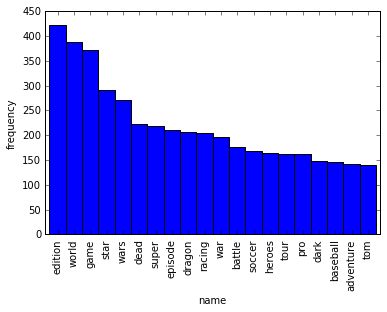

In [5]:
DISTRACTIONS = ["i", "ii", "iii", "iv", "v", "vi", "vii", "fifa", "nba", "nfl", "vs", "k", "one", "two", "three", "four", "pga", "nhl", "ncaa"]

# Shows the word frequency of game titles with a bar graph
## make_graph (boolean) - Generates a bar graph if true, otherwise prints the standart pandas representation
## how_many (number) - Number of game instances to show
# TODO: words preprocessing can be inside of the item_counter
def see_every_game_name(make_graph, how_many):
    spec = data["title"]
    words = preprocess(DISTRACTIONS, spec)
    
    result = item_counter(words, how_many, False)
    if make_graph:
            make_bar_graph(result, 'name', 'frequency')
    else:
            return result
        
#see_every_game_name(True, 20)

In [6]:
# Shows the word frequency of game titles with a bar graph using a score limit
## min_score (number) - Game names with scores >= min_score will be considered
## make_graph (boolean) - Generates a bar graph if true, otherwise prints the standart pandas representation
## how_many (number) - Number of game instances to show
def see_game_names_with_score_limit(min_score, make_graph, how_many):
    # games_by_score = data.sort("score")       # optional #
    spec = games_by_score.loc[games_by_score["score"] >= min_score]["title"]
    words = preprocess(DISTRACTIONS, spec)
    
    result = item_counter(words, how_many, False)
    if make_graph:
            make_bar_graph(result, 'name', 'frequency')
    else:
            return result

see_game_names_with_score_limit(8.0, False, 30)

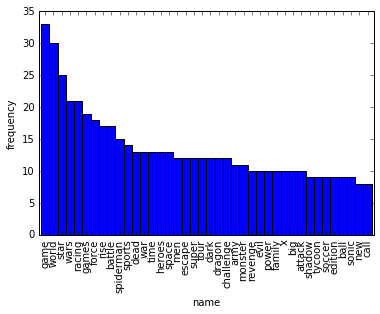

In [7]:
# Shows the word frequency of game titles with a bar graph using a classificiation (release_year, score_phrase etc) and a key (1996, "Amazing" etc.)
## classification (string) - Column name to specify the data
## key (string) - A key that is wanted to be matched to the classification column
## make_graph (boolean) - Generates a bar graph if true, otherwise prints the standart pandas representation
## how_many (number) - Number of game instances to show
def see_game_names_with_key(classification, key, make_graph, how_many):
    spec = games_by_year.loc[games_by_year[classification] == key]["title"]
    words = preprocess(DISTRACTIONS, spec)
    
    result = item_counter(words, how_many, False)
    if make_graph:
        make_bar_graph(result, 'name', 'frequency')
    else:
        return result
        
see_game_names_with_key("score_phrase", "Bad", True, 40)

In [8]:
see_game_names_with_key("release_year", 2009, True, 20)

//TODO: Generate game names that are > 7.5